In [19]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from tensorflow.keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt


* We'll work with the Sequential API. It's the easiest way to structure your Keras layers (contrary to the Functional API), but it comes with a cost - you lose flexibility in terms of how data flows through your model, as you literally stack all layers. For this blog post, that doesn't matter, but it may be an idea to inform yourself about the differences between both APIs.
##### Imported  layers:
- The **Dense** layer represents the densely-connected layers (MLP-like layers) that we will use to classify the very abstract 3D convolutional feature maps into one of the buckets 0-9, for the digits 0-9.
- The **Flatten** layer will be used to convert the multidimensional feature map into a one-dimensional array, since only those can be handled by densely-connected layers.
- The **Conv3D** layer, which was intuitively discussed above, will be used for performing the convolutional operations.
- In between the convolutional layers, we apply three-dimensional max pooling with **MaxPooling3D** in order to down-sample the feature maps (or in plain English: making them smaller, presumably without losing information) which saves precious computational resources.

### Model Configuration

In [2]:
# Model Configuration
batch_size = 100
no_epochs = 30
learning_rate = 0.001
no_classes = 10
validation_split = 0.2
verbosity = 1

**Specifically, we configure the model as follows:**

* We use a **batch size** of 100 samples. This means that one hundred samples are fed forward through the network each time, generating predictions, computing loss, and optimization. The higher the batch size, the higher the efficiency with which the improvement gradient can be computed, but the more memory is required.
* We use **30 epochs.** One epoch, or full iteration, means that all samples are fed forward once, and that the process can start over again. It is possibly to dynamically determine the number of epochs, but for the sake of simplicity we just choose 30.
- **The learning rate**, or the aggressiveness with which the optimizer (in our case, the Adam optimizer) will attempt to improve once the gradient is known, is set to 0.001.
- We obviously have 10 classes (the digits 0 up to and including 9), so **no_classes** is 10.
* Twenty percent or 0.2 of the training data is used as validation data, so this defines our **validation_split**.
* Finally, we set **verbosity** to 1, which means that all possible output is output to our screens. This helps in understanding what happens, but slightly slows down the process. Hence, if you're using those models for real, you may wish to turn verbose mode off, but for now, it's going to be useful.

In [8]:
# Adding Helper function

# Convert 1D vector into 3D values,
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]

# Reshape data into format that can be handled by conv3D layers

def rgb_data_transform(data):
    data_t =[]
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)

myarr = [1, 2, 3, 4, 5, 6]
print(myarr[:])

[1, 2, 3, 4, 5, 6]


**What array_to_color does?**
* The imported data will be of one channel only. This function converts the data into RGB format, and hence into three channels. This ensures resemblence with the original 2D scenario.

* Next, we use **rgb_data_transform**, which was created by machine learning students Sam Berglin, Zheming Lian and Jiahui Jang at the University of Wisconsin-Madison. Under guidance of professor Sebastian Raschka, whose Mlxtend library we use quite often, they also created a 3D ConvNet for the 3D MNIST dataset, but then using PyTorch instead of Keras.

* The function reshapes the data, which per sample comes in a (4096,) shape (16x16x16 pixels = 4096 pixels), so in a one-dimensional array. Their function reshapes the data into three-channeled, four-dimensional 16x16x16x3 format, making use of array_to_color. The Conv3D function can now handle the data.

## Data preparation
We can next import and prepare the data.

In [13]:
# Load the HDF5 file

with  h5py.File("./full_dataset_vectors.h5", "r") as hf:
    
    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:]
    targets_test = hf["y_test"][:]
    
    # Determine sample shape
    sample_shape = (16, 16, 16, 3)
    
    # Reshape the data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)
    
    # Convert target vectors to categorical targets
    targets_train = to_categorical(targets_train).astype(np.int64)
    targets_test = to_categorical(targets_test).astype(np.int64)
    

## Model Architecture and Training

In [20]:
# First the architecture

## Adding Dropout to reduce overfitting. 

model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

- As discussed, we use the Keras Sequential API with Conv3D, MaxPooling3D, Flatten and Dense layers.

- Specifically, we use two three-dimensional convolutional layers with 3x3x3 kernels, ReLU activation functions and hence He uniform init.

- 3D max pooling is applied with 2x2x2 pool sizes.

- Once the convolutional operations are completed, we Flatten the feature maps and feed the result to a Dense layer which also activates and initializes using the ReLU/He combination.

- Finally, we output the data into a Dense layer with no_classes (= 10) neurons and a Softmax activation function. This activation function generates a multiclass probability distribution over all the possible target classes, essentially a vector with probabilities that the sample belongs to that particular class, all values summing to 100% (or, statistically, 1).

**Second - the training procedure:

In [21]:
# Compile the model

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, 
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate), 
              metrics=['accuracy'])

# Fit data to model
history = model.fit(X_train, targets_train, 
                    batch_size=batch_size, 
                    epochs=no_epochs, 
                    verbose=verbosity,
                   validation_split=validation_split)

Epoch 1/30
80/80 [==============================] - 62s 768ms/step - loss: 2.5262 - accuracy: 0.1089 - val_loss: 2.2990 - val_accuracy: 0.1220
Epoch 2/30
80/80 [==============================] - 61s 761ms/step - loss: 2.2711 - accuracy: 0.1471 - val_loss: 2.1846 - val_accuracy: 0.2745
Epoch 3/30
80/80 [==============================] - 61s 761ms/step - loss: 2.1279 - accuracy: 0.2307 - val_loss: 1.9790 - val_accuracy: 0.3530
Epoch 4/30
80/80 [==============================] - 61s 759ms/step - loss: 1.9827 - accuracy: 0.2928 - val_loss: 1.8377 - val_accuracy: 0.4085
Epoch 5/30
80/80 [==============================] - 62s 780ms/step - loss: 1.8477 - accuracy: 0.3470 - val_loss: 1.6980 - val_accuracy: 0.4655
Epoch 6/30
80/80 [==============================] - 66s 823ms/step - loss: 1.7346 - accuracy: 0.3877 - val_loss: 1.5770 - val_accuracy: 0.5130
Epoch 7/30
80/80 [==============================] - 62s 774ms/step - loss: 1.6177 - accuracy: 0.4297 - val_loss: 1.4107 - val_accuracy: 0.5390

We first ```compile``` the model which essentially configures the architecture according to the hyperparameters that we set in the configuration section.

Next, we ``fit`` the data to the model, using the other configuration settings set before. Fitting the data starts the training process. The output of this training process is stored in the ``history`` object which we can use for visualization purposes.

## Model Evaluation

Test loss: 1.017402172088623/ Test accuracy: 0.6470000147819519


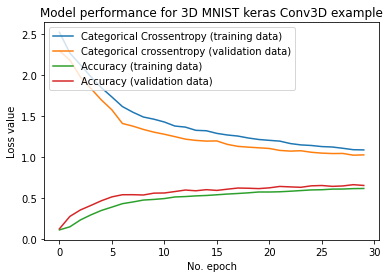

In [23]:
# Generate generalization metrics
score = model.evaluate(X_test, targets_test, verbose=0)
print(f'Test loss: {score[0]}/ Test accuracy: {score[1]}')

# plot history: Categorical crossendtropy & Accuracy
plt.plot(history.history['loss'], label='Categorical Crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Battling overfitting
#### Adding Dropout.

- Adding Dropout to the model architecture allows us to 'drop' random elements from the feature maps during training. Although this confuses the model, it disallows it to adapt too much to the training data: